In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from torch.optim import Adam, lr_scheduler
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

# Dataset

It is a many-to-many task.

In [2]:
narma_df = pd.read_csv('NARMA10.csv', header=None).transpose()
narma_df.columns = ['input', 'target']


narma_df.head(15)

,input,target
0,0.083964,0.00000
1,0.489340,0.00000
2,0.356350,0.00000
3,0.250240,0.00000
4,0.235540,0.00000
5,0.029809,0.00000
6,0.340990,0.00000
7,0.021216,0.00000
8,0.035723,0.00000
9,0.260820,0.00000


In [3]:
narma_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   input   10000 non-null  float64
 1   target  10000 non-null  float64
dtypes: float64(2)
memory usage: 234.4 KB


Show first 10 elems of the series

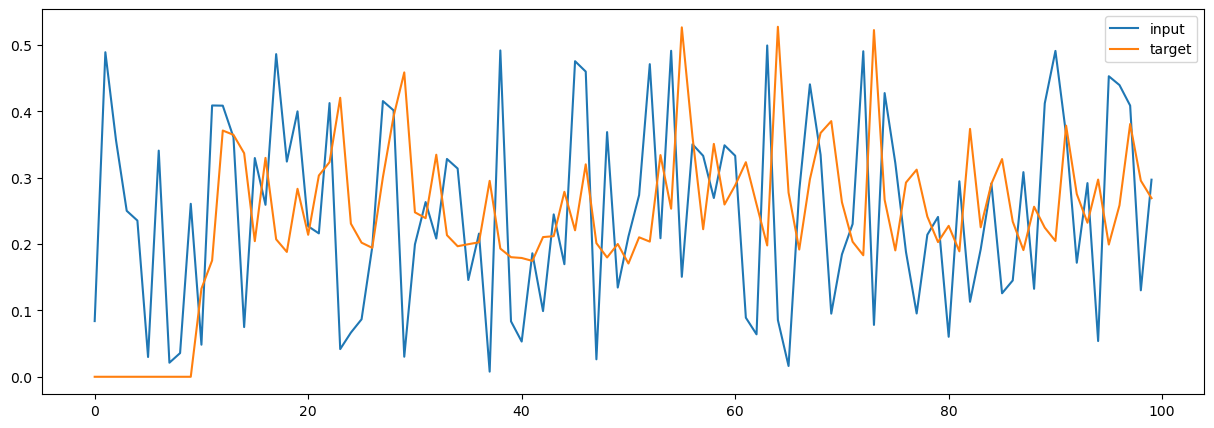

In [4]:
plt.plot(narma_df['input'][:100], label='input')
plt.plot(narma_df['target'][:100], label='target')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()

## Split Tr - Val - Test

In [5]:
tr_df = narma_df.iloc[:4000]
val_df = narma_df.iloc[4000:5000]
test_df = narma_df.iloc[5000:]

## Prepare datsets

In [6]:
tr_input = tr_df.input.values
tr_target = tr_df.target.values

val_input = val_df.input.values
val_target = val_df.target.values

test_input = test_df.input.values
test_target = test_df.target.values

devel_input = np.concatenate([tr_input, val_input])
devel_target = np.concatenate([tr_target, val_target])

print(tr_input.shape, tr_target.shape)

(4000,) (4000,)


In [7]:
batch_size = 32

tr_dataloader = DataLoader(torch.tensor([tr_df.input.values, tr_df.target.values]), batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(torch.tensor([val_df.input.values, val_df.target.values]), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(torch.tensor([test_df.input.values, test_df.target.values]), batch_size=batch_size, shuffle=False)

/tmp/ipykernel_4446/4131595575.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402411778/work/torch/csrc/utils/tensor_new.cpp:245.)
  tr_dataloader = DataLoader(torch.tensor([tr_df.input.values, tr_df.target.values]), batch_size=batch_size, shuffle=False)


# TDNN

Time delay neural network object. It has a dynamic architecture, which is defined by the number of layers and the number of neurons in each layer.

In [8]:
class tdnn(nn.Module):
    def __init__(self, delay=10, hidden_layers_dim=[10], dropout=0.2, activation='relu',  *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layers = nn.ModuleList()
        self.delay = delay

        # Delay corresponds to the input dimension
        prev_dim = delay
        for hidden_dim in hidden_layers_dim:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            if activation == 'relu':
                self.layers.append(nn.ReLU())
            elif activation == 'tanh':
                self.layers.append(nn.Tanh())
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim

        self.layers.append(nn.Linear(hidden_layers_dim[-1], 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Some utility functions for the TDNN.

In [9]:
# Given a padded array and a an index, it returns the elem at index position and previous 'delay-1' elements
def get_delayed_input(padded_arr, index, delay):
    index_start = index - delay + 1
    if index_start < 0:
        raise Exception('Start index cannot be negative')
    index_end = index+1
    return padded_arr[index_start:index_end]

In [10]:
# Evaluate the tdnn (loop over the samples)
def eval_tdnn(X_val, Y_val, model, loss_function, device='cpu'):
    model.eval()
    model.to(device)

    preds = []

    val_loss_total = 0
    padded_X_val = np.pad(X_val, (model.delay, 0), 'constant', constant_values=0)

    with torch.no_grad():
        for idx, y in enumerate(Y_val):
            # Get input delayed vector
            x_idx = idx + model.delay
            x = get_delayed_input(padded_X_val, x_idx, model.delay)
            # Convert to tensor
            x = torch.tensor(x, dtype=torch.float32).to(device)
            y = torch.tensor(y, dtype=torch.float32).to(device)

            pred = model(x)
            pred = torch.squeeze(pred)
            loss = loss_function(pred, y)
            val_loss_total += loss.item()
            preds.append(pred.item())

    val_loss = torch.tensor(val_loss_total / len(Y_val))
    preds = np.array(preds)
    return val_loss, preds

In [11]:
# Train the tdnn  afor 1 epoch (samples loop)
def train_tdnn(X_tr, Y_tr, model, loss_function, optimizer, scheduler, device='cpu'):
        tr_loss_total = 0
        preds = []

        # Train for 1 epoch
        model.to(device)
        model.train()
        # Get the input padded by the delay
        padded_X_tr = np.pad(X_tr, (model.delay, 0), 'constant', constant_values=0)
        for idx, y in enumerate(Y_tr):
            optimizer.zero_grad()
            # Get input delayed vector
            x_idx = idx + model.delay
            x = get_delayed_input(padded_X_tr, x_idx, model.delay)
            # Convert to tensor
            x = torch.tensor(x, dtype=torch.float32).to(device)
            y = torch.tensor(y, dtype=torch.float32).to(device)

            pred = model(x)
            pred = torch.squeeze(pred)
            loss = loss_function(pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()

            tr_loss_total += loss.item()
            preds.append(pred.item())

        tr_loss = torch.tensor(tr_loss_total / len(Y_tr))
        preds = np.array(preds)
        return tr_loss, preds, model, optimizer, scheduler

In [12]:
# Initialize the tdnn network, scheduler, optimizer and loss function
def init_network(delay, hidden_layers_dim, dropout, lr_rate=1e-5, gamma=0.9, activation='relu'):
    tdnn_model = tdnn(delay=delay, hidden_layers_dim=hidden_layers_dim, dropout=dropout, activation=activation)
    loss_function = torch.nn.MSELoss()
    optimizer = Adam(params = tdnn_model.parameters(), lr=lr_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

    return tdnn_model, loss_function, optimizer, scheduler

In [13]:
num_epochs = 20

Grid search params

In [14]:
hidden_layers_dim_list = [[16], [64], [64, 16]]
lr_list = [1e-5, 1e-4, 1e-3]
gamma_list = [0.9, 0.999]
dropout_list = [0.0, 0.2]
delay_list = [5, 10, 20]
activation_list = ['relu', 'tanh']

Grid search over the hyperparams. 

Once a better model on val loss is found, it is set as the current best model.

In [15]:
best_val_loss = math.inf

for hidden_layers_dim in hidden_layers_dim_list:
    for lr in lr_list:
        for gamma in gamma_list:
            for dropout in dropout_list:
                for delay in delay_list:
                    for activation in activation_list:
                        print('Training with delay: {}, hidden_layers_dim: {}, lr: {} gamma: {}, dropout: {}, activation: {}'
                              .format(delay, hidden_layers_dim, lr, gamma, dropout, activation))

                        tdnn_model, loss_function, optimizer, scheduler = init_network(delay, hidden_layers_dim, dropout, lr, gamma, activation)

                        # Epochs loop
                        tr_loss_list, val_loss_list = [], []

                        pbar = tqdm(range(num_epochs)) 
                        for epoch in pbar:
                            # Train the model
                            tr_loss, _, tdnn_model, optimizer, scheduler = train_tdnn(tr_input, tr_target, tdnn_model, loss_function, optimizer, scheduler)
                            tr_loss_list.append(tr_loss)
                            # Evaluate the model
                            val_loss, _ = eval_tdnn(val_input, val_target, tdnn_model, loss_function)
                            val_loss_list.append(val_loss)

                            pbar.set_description(f"Tr Loss: {tr_loss.item():0.4f} - Val Loss: {val_loss.item():0.4f}")

                            
                        # Get the best val loss and corresponding epoch of the current model
                        min_val_loss = min(val_loss_list)
                        min_val_loss_epoch = val_loss_list.index(min_val_loss)

                        # Save the current model if its best validation loss is better than the best validation loss so far
                        if min_val_loss < best_val_loss:
                            best_val_loss = min_val_loss
                            best_val_loss_epoch = min_val_loss_epoch
                            best_hidden_layers_dim = hidden_layers_dim
                            best_lr = lr
                            best_gamma = gamma
                            best_dropout = dropout
                            best_delay = delay
                            best_activation = activation
                            best_tr_loss_list = tr_loss_list
                            best_val_loss_list = val_loss_list

Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0597 - Val Loss: 0.0588: 100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0108 - Val Loss: 0.0110: 100%|██████████| 20/20 [01:23<00:00,  4.16s/it]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.1001 - Val Loss: 0.0990: 100%|██████████| 20/20 [01:24<00:00,  4.20s/it]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.2590 - Val Loss: 0.2570: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.2552 - Val Loss: 0.2547: 100%|██████████| 20/20 [01:24<00:00,  4.24s/it]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0252 - Val Loss: 0.0251: 100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.1343 - Val Loss: 0.1310: 100%|██████████| 20/20 [01:28<00:00,  4.45s/it]


Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0273 - Val Loss: 0.0111: 100%|██████████| 20/20 [01:07<00:00,  3.38s/it]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0967 - Val Loss: 0.0907: 100%|██████████| 20/20 [01:03<00:00,  3.19s/it]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0215 - Val Loss: 0.0194: 100%|██████████| 20/20 [01:03<00:00,  3.15s/it]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.2009 - Val Loss: 0.1990: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0670 - Val Loss: 0.0651: 100%|██████████| 20/20 [01:09<00:00,  3.48s/it]


Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.2927 - Val Loss: 0.2911: 100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.2418 - Val Loss: 0.2397: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0106 - Val Loss: 0.0105: 100%|██████████| 20/20 [01:02<00:00,  3.12s/it]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0062 - Val Loss: 0.0060: 100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0281 - Val Loss: 0.0281: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.1662 - Val Loss: 0.1651: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.1307 - Val Loss: 0.1228: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0288 - Val Loss: 0.0248: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0418 - Val Loss: 0.0400: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0272 - Val Loss: 0.0212: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.1089 - Val Loss: 0.1071: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0184 - Val Loss: 0.0168: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0899 - Val Loss: 0.0883: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1060 - Val Loss: 0.1047: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0265 - Val Loss: 0.0257: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1394 - Val Loss: 0.1373: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0251 - Val Loss: 0.0239: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0145 - Val Loss: 0.0144: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.2654 - Val Loss: 0.2575: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.1146 - Val Loss: 0.1061: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0310 - Val Loss: 0.0287: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0123 - Val Loss: 0.0106: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0763 - Val Loss: 0.0742: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0083 - Val Loss: 0.0080: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0074 - Val Loss: 0.0073: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0116 - Val Loss: 0.0116: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0079 - Val Loss: 0.0081: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0094 - Val Loss: 0.0093: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0046 - Val Loss: 0.0050: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0095 - Val Loss: 0.0105: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0294 - Val Loss: 0.0262: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0134 - Val Loss: 0.0077: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0102 - Val Loss: 0.0091: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0111 - Val Loss: 0.0072: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0112 - Val Loss: 0.0070: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0099 - Val Loss: 0.0072: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.2090 - Val Loss: 0.2065: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0112 - Val Loss: 0.0111: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0827 - Val Loss: 0.0815: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1847 - Val Loss: 0.1828: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0140 - Val Loss: 0.0137: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1045 - Val Loss: 0.1037: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.2294 - Val Loss: 0.2247: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0246 - Val Loss: 0.0180: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0819 - Val Loss: 0.0803: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.3453 - Val Loss: 0.3410: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0180 - Val Loss: 0.0160: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.1221 - Val Loss: 0.1175: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0048 - Val Loss: 0.0048: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0050 - Val Loss: 0.0050: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0050 - Val Loss: 0.0050: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0050 - Val Loss: 0.0049: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0012 - Val Loss: 0.0016: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0016 - Val Loss: 0.0017: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0064 - Val Loss: 0.0057: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 5, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0087 - Val Loss: 0.0055: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0070 - Val Loss: 0.0057: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 10, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0068 - Val Loss: 0.0061: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0029 - Val Loss: 0.0019: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 20, hidden_layers_dim: [16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0067 - Val Loss: 0.0035: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0654 - Val Loss: 0.0643: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0269 - Val Loss: 0.0263: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.1304 - Val Loss: 0.1297: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1063 - Val Loss: 0.1053: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.1525 - Val Loss: 0.1505: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0282 - Val Loss: 0.0276: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0343 - Val Loss: 0.0310: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0474 - Val Loss: 0.0415: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.1506 - Val Loss: 0.1481: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0456 - Val Loss: 0.0435: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.1340 - Val Loss: 0.1309: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0949 - Val Loss: 0.0918: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0125 - Val Loss: 0.0121: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0139 - Val Loss: 0.0138: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0079 - Val Loss: 0.0079: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0260 - Val Loss: 0.0261: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0236 - Val Loss: 0.0237: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.1634 - Val Loss: 0.1616: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0503 - Val Loss: 0.0454: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0237 - Val Loss: 0.0205: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0462 - Val Loss: 0.0440: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0157 - Val Loss: 0.0128: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0300 - Val Loss: 0.0297: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0135 - Val Loss: 0.0121: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0952 - Val Loss: 0.0946: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1433 - Val Loss: 0.1418: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0961 - Val Loss: 0.0945: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1205 - Val Loss: 0.1192: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.1157 - Val Loss: 0.1144: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1225 - Val Loss: 0.1214: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0130 - Val Loss: 0.0113: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.1782 - Val Loss: 0.1723: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.2819 - Val Loss: 0.2767: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.1400 - Val Loss: 0.1352: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0127 - Val Loss: 0.0108: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.1486 - Val Loss: 0.1453: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0067 - Val Loss: 0.0069: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0051 - Val Loss: 0.0052: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0071 - Val Loss: 0.0073: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0071 - Val Loss: 0.0073: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0072 - Val Loss: 0.0075: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0051 - Val Loss: 0.0052: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0107 - Val Loss: 0.0056: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0118 - Val Loss: 0.0080: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0148 - Val Loss: 0.0087: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0085 - Val Loss: 0.0061: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0073 - Val Loss: 0.0048: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0086 - Val Loss: 0.0063: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0875 - Val Loss: 0.0862: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0702 - Val Loss: 0.0696: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0786 - Val Loss: 0.0771: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0590 - Val Loss: 0.0585: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.1954 - Val Loss: 0.1927: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0371 - Val Loss: 0.0375: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0289 - Val Loss: 0.0258: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0630 - Val Loss: 0.0592: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0494 - Val Loss: 0.0469: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0895 - Val Loss: 0.0869: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0998 - Val Loss: 0.0971: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0555 - Val Loss: 0.0528: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0046 - Val Loss: 0.0045: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0046 - Val Loss: 0.0046: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0046 - Val Loss: 0.0046: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0046 - Val Loss: 0.0045: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0010 - Val Loss: 0.0012: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0011 - Val Loss: 0.0013: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0055 - Val Loss: 0.0045: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Training with delay: 5, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0067 - Val Loss: 0.0046: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0058 - Val Loss: 0.0048: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


Training with delay: 10, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0056 - Val Loss: 0.0046: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0027 - Val Loss: 0.0015: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Training with delay: 20, hidden_layers_dim: [64], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0026 - Val Loss: 0.0013: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0326 - Val Loss: 0.0320: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0833 - Val Loss: 0.0824: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0654 - Val Loss: 0.0645: 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0093 - Val Loss: 0.0092: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0936 - Val Loss: 0.0923: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1291 - Val Loss: 0.1279: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.2785 - Val Loss: 0.2718: 100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0214 - Val Loss: 0.0180: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0642 - Val Loss: 0.0634: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0393 - Val Loss: 0.0359: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0324 - Val Loss: 0.0317: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.1301 - Val Loss: 0.1278: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0088 - Val Loss: 0.0086: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0271 - Val Loss: 0.0266: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0123 - Val Loss: 0.0122: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.1241 - Val Loss: 0.1230: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0547 - Val Loss: 0.0545: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0114 - Val Loss: 0.0112: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0329 - Val Loss: 0.0307: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0201 - Val Loss: 0.0189: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0087 - Val Loss: 0.0084: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0141 - Val Loss: 0.0123: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.1234 - Val Loss: 0.1175: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 1e-05 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0086 - Val Loss: 0.0077: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0130 - Val Loss: 0.0127: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0171 - Val Loss: 0.0166: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.1110 - Val Loss: 0.1097: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.2839 - Val Loss: 0.2821: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.3010 - Val Loss: 0.2986: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0954 - Val Loss: 0.0942: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0093 - Val Loss: 0.0081: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0955 - Val Loss: 0.0948: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.1088 - Val Loss: 0.1089: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.1494 - Val Loss: 0.1425: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.1215 - Val Loss: 0.1216: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0837 - Val Loss: 0.0832: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0061 - Val Loss: 0.0061: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0067 - Val Loss: 0.0067: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0073 - Val Loss: 0.0073: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0078 - Val Loss: 0.0080: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0052 - Val Loss: 0.0053: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0062 - Val Loss: 0.0063: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0072 - Val Loss: 0.0065: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0075 - Val Loss: 0.0069: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0090 - Val Loss: 0.0072: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0155 - Val Loss: 0.0076: 100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0072 - Val Loss: 0.0066: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.0001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0173 - Val Loss: 0.0072: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0732 - Val Loss: 0.0720: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.1505 - Val Loss: 0.1488: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.1377 - Val Loss: 0.1369: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0693 - Val Loss: 0.0688: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: relu


Tr Loss: 0.0342 - Val Loss: 0.0335: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.0, activation: tanh


Tr Loss: 0.0592 - Val Loss: 0.0586: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0478 - Val Loss: 0.0479: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0529 - Val Loss: 0.0513: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0658 - Val Loss: 0.0639: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0879 - Val Loss: 0.0845: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: relu


Tr Loss: 0.0816 - Val Loss: 0.0786: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.9, dropout: 0.2, activation: tanh


Tr Loss: 0.0128 - Val Loss: 0.0119: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0046 - Val Loss: 0.0045: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0046 - Val Loss: 0.0045: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0046 - Val Loss: 0.0045: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0047 - Val Loss: 0.0046: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: relu


Tr Loss: 0.0010 - Val Loss: 0.0011: 100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.0, activation: tanh


Tr Loss: 0.0014 - Val Loss: 0.0014: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0057 - Val Loss: 0.0046: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Training with delay: 5, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0053 - Val Loss: 0.0047: 100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0069 - Val Loss: 0.0048: 100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Training with delay: 10, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0059 - Val Loss: 0.0048: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: relu


Tr Loss: 0.0038 - Val Loss: 0.0015: 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Training with delay: 20, hidden_layers_dim: [64, 16], lr: 0.001 gamma: 0.999, dropout: 0.2, activation: tanh


Tr Loss: 0.0027 - Val Loss: 0.0012: 100%|██████████| 20/20 [00:26<00:00,  1.35s/it]


In [16]:
print('Best validation loss: {} at epoch {}, NN with {} hidden layers, lr={}, gamma={}, dropout={}, delay={}, activation={}'
      .format(best_val_loss, best_val_loss_epoch, best_hidden_layers_dim, best_lr, best_gamma, best_dropout, best_delay, best_activation))

# Save tr and val loss lists (epoch by epoch)
tdnn_folder = 'tdnn'
if not os.path.exists(tdnn_folder):
      os.makedirs(tdnn_folder)

tr_loss_list_file = os.path.join(tdnn_folder, 'tr_loss_list.npy')
val_loss_list_file = os.path.join(tdnn_folder, 'val_loss_list.npy')
np.save(tr_loss_list_file, best_tr_loss_list)
np.save(val_loss_list_file, best_val_loss_list)

Best validation loss: 0.001118559273891151 at epoch 2, NN with [64, 16] hidden layers, lr=0.001, gamma=0.999, dropout=0.0, delay=20, activation=relu


Visualize training and validation curves.

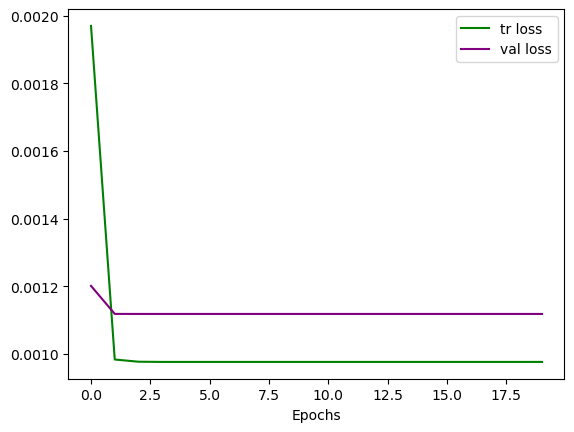

In [19]:
plt.plot(best_tr_loss_list, label='tr loss', color='green')
plt.plot(best_val_loss_list, label='val loss', color='purple')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Retrain

Retrain on full development (train + validation) set.

In [20]:
lr = 0.001
gamma = 0.999
dropout = 0.0
delay = 20
hidden_layers_dim = [64, 16]
activation = 'relu'

In [21]:
retrain_tdnn_model, loss_function, optimizer, scheduler = init_network(delay, hidden_layers_dim, dropout, lr, gamma, activation)

# Save retrain model for each epoch
tdnn_retrain_checkpoint_folder = 'tdnn_retrain_checkpoint'
if not os.path.exists(tdnn_retrain_checkpoint_folder):
        os.makedirs(tdnn_retrain_checkpoint_folder)

retrain_loss_list =[]

# Epochs loop
pbar = tqdm(range(num_epochs)) 
for epoch in pbar:
    # Train the model
    tr_loss, preds, retrain_tdnn_model, optimizer, scheduler = train_tdnn(devel_input, devel_target, retrain_tdnn_model, loss_function, optimizer, scheduler)
    retrain_loss_list.append(tr_loss)

    pbar.set_description(f"Retrain Loss: {tr_loss.item():0.4f}")

     # Save
    model_save_pth = os.path.join(tdnn_retrain_checkpoint_folder, 'tdnn_{}.pt'.format(epoch))
    torch.save({
                'epoch': epoch,
                'model_state_dict': retrain_tdnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schdeduler_state_dict': scheduler.state_dict(),
                'tr_loss': tr_loss,
                'tr_preds': preds
                }, model_save_pth)

Retrain Loss: 0.0010: 100%|██████████| 20/20 [00:37<00:00,  1.90s/it]


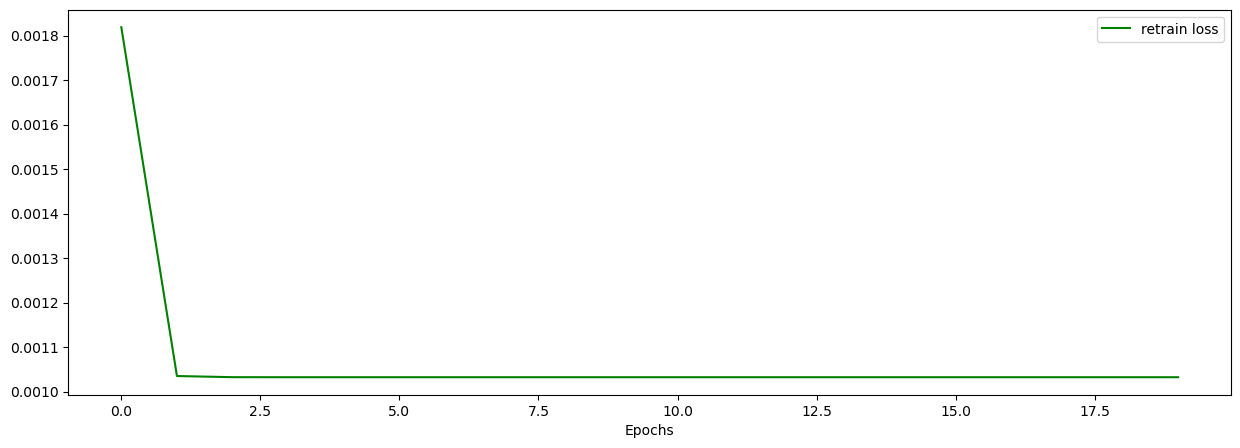

In [22]:
plt.plot(retrain_loss_list, label='retrain loss', color='green')
plt.xlabel('Epochs')
plt.gcf().set_size_inches(15, 5)
plt.legend()

In [23]:
print('Best retrain loss: {} at epoch {}'.format(min(retrain_loss_list), retrain_loss_list.index(min(retrain_loss_list))))

Best retrain loss: 0.0010323295136913657 at epoch 3


Best epoch for retrained TDNN: loss flattens just after the first epoch, so we choose the checkopint at epoch 1.

In [24]:
final_retrain_pth = './tdnn_retrain_checkpoint/tdnn_1.pt'


best_tdnn_retrain = tdnn(delay=delay, hidden_layers_dim=hidden_layers_dim, dropout=dropout)
best_tdnn_retrain.load_state_dict(torch.load(final_retrain_pth)['model_state_dict'])

# Preds of the best tdnn retrain model
retrain_preds = torch.load(final_retrain_pth)['tr_preds']

Plot predicted and true values of the series for the development set.

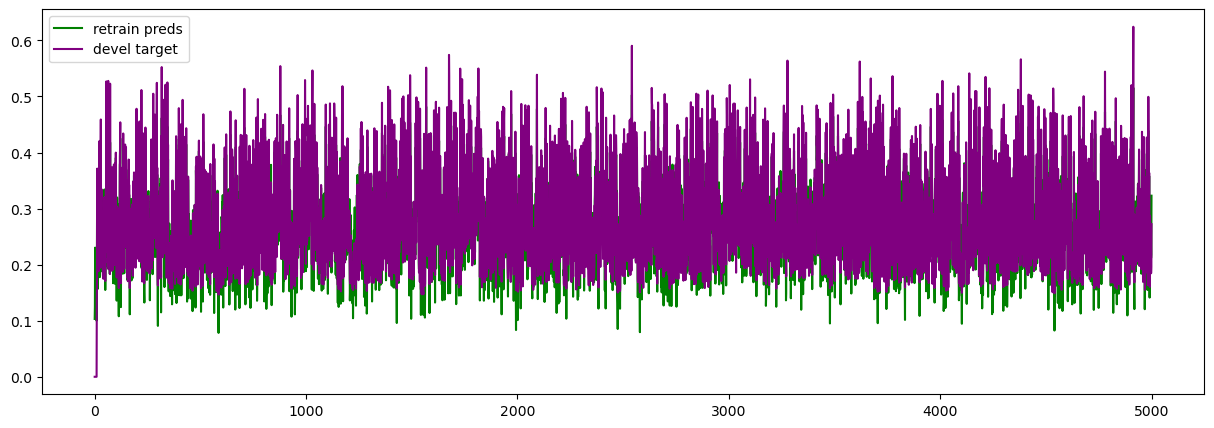

In [25]:
plt.plot(retrain_preds, label='retrain preds', color='green')
plt.plot(devel_target, label='devel target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()


Show test predictions of the first 1000 elems.

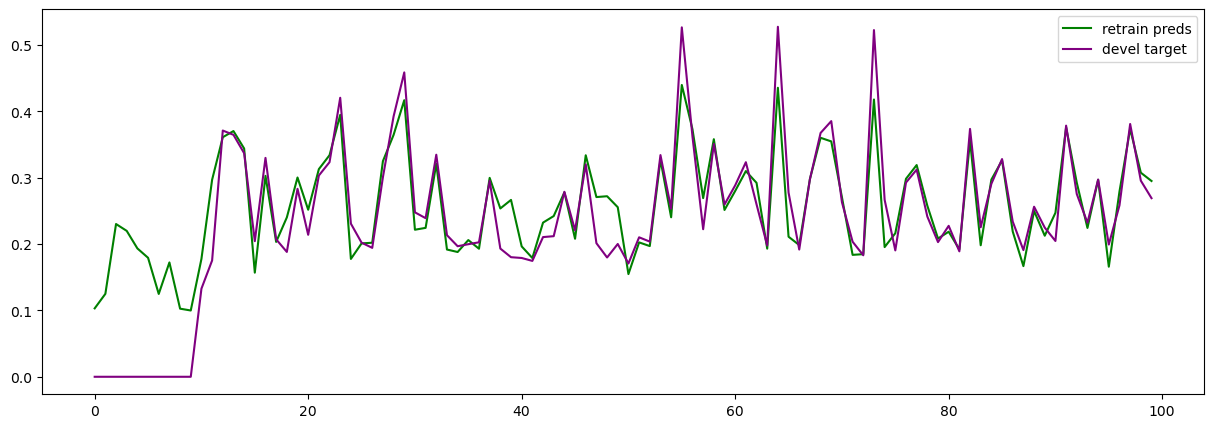

In [26]:
plt.plot(retrain_preds[:100], label='retrain preds', color='green')
plt.plot(devel_target[:100], label='devel target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()

## Test

Get test predictions.

In [27]:
# Save test preds and loss

test_loss, test_preds = eval_tdnn(test_input, test_target, best_tdnn_retrain, loss_function)
torch.save({
            'test_loss': test_loss,
            'test_preds': test_preds
}, 'tdnn_test.pt')

Plot predicted and true values of the series for the test set.

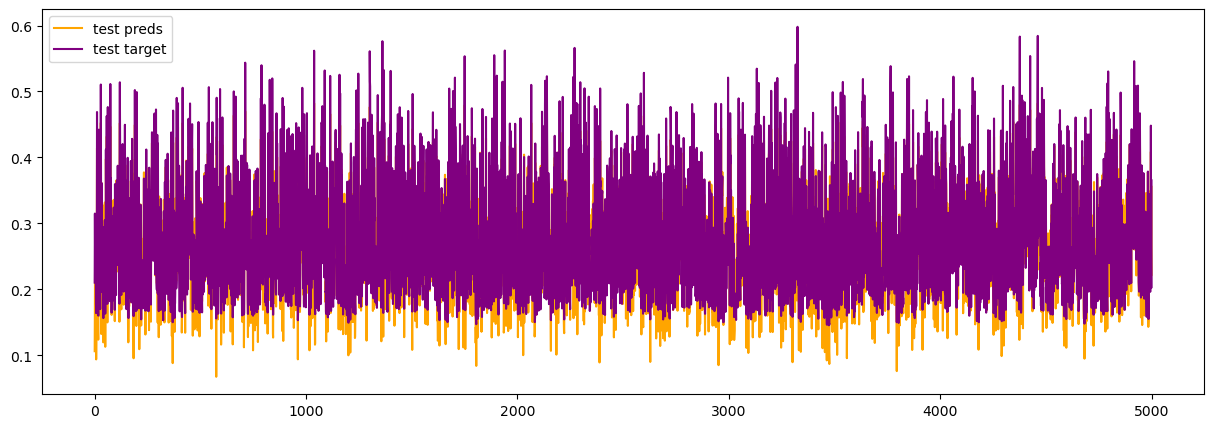

In [28]:
plt.plot(test_preds, label='test preds', color='orange')
plt.plot(test_target, label='test target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()

Show test predictions vs targets of the first 100 elems.

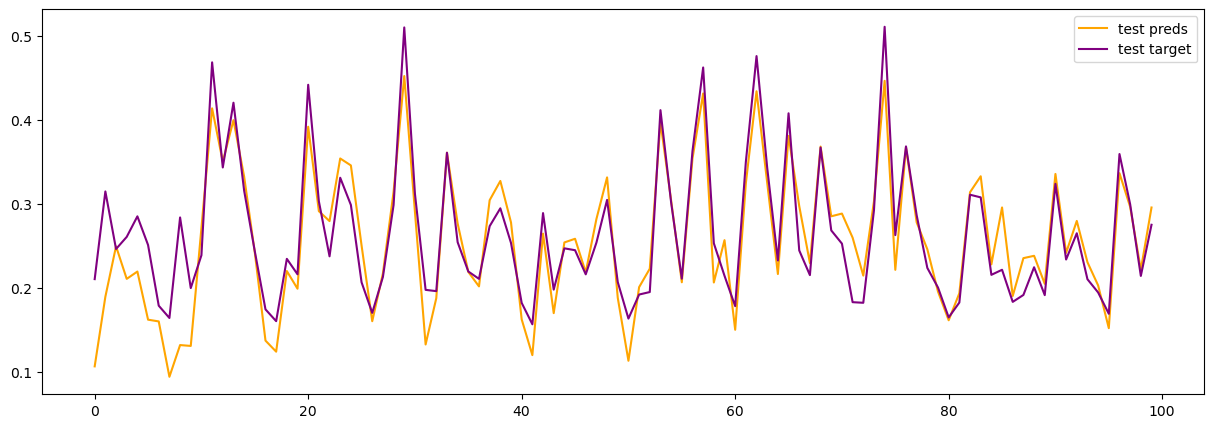

In [29]:
plt.plot(test_preds[:100], label='test preds', color='orange')
plt.plot(test_target[:100], label='test target', color='purple')
plt.gcf().set_size_inches(15, 5)
plt.legend()
plt.show()